<a href="https://colab.research.google.com/github/Charliebond125/MEGNet/blob/main/KFoldCV_Modelling_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/vlawhern/arl-eegmodels.git

fatal: destination path 'arl-eegmodels' already exists and is not an empty directory.


In [ ]:
!pip install mne

In [ ]:
import numpy as np
import pandas as pd
import mne
from mne import read_epochs
from mne import pick_types, Epochs
from mne.channels import read_layout
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')

# tools for plotting confusion matrices
from matplotlib import pyplot as plt
import tensorflow as tf

import sys, os

sys.path.append('/content/arl-eegmodels')

from EEGModels import EEGNet, ShallowConvNet, DeepConvNet

# Initialize a DataFrame to store the results
results_df = pd.DataFrame(columns=['Event Pair', 'AUC Score', 'kl', 'd'])

In [ ]:
# Function to preprocess the data for a specific event pair
def preprocess_data(event_pair_function, epochs_data):
    epochs_data_selected = event_pair_function(epochs_data)

    # Select only gradiometer channels
    grad_channels = mne.pick_types(epochs_data_selected.info, meg='grad')
    grad_channel_names = [epochs_data_selected.ch_names[ch] for ch in grad_channels]
    epochs_data_selected = epochs_data_selected.pick_channels(grad_channel_names)

    return epochs_data_selected

# Function to train and evaluate the model for a specific event pair
def train_and_evaluate_model(X_train, y_train, X_test, y_test, kl_values, d_values, n_epochs):
    # Initialize variables to store the highest AUC score and corresponding kl value
    highest_auc_score = 0
    best_kl = None
    best_d = None



    # Iterate over the kl and d values
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    for kl in kl_values:
        for d in d_values:
            print()
            print("Current kl:", kl)
            print("Current d:", d)
            print()

            # Configure the EEGNet model
            model = EEGNet(nb_classes=y_train.shape[1], Chans=X_train.shape[1], Samples=X_train.shape[2], dropoutRate=d, kernLength=kl)

            # Compile the model
            model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

            # Set a valid path for model checkpoints
            checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1, save_best_only=True)

            # Class weights
            class_weights = {0: 1, 1: 1}

            # Fit the model to the training data
            history = model.fit(X_train, y_train, batch_size=16, epochs=n_epochs, verbose=2,
                                validation_split=0.1, callbacks=[checkpointer, EarlyStopping(patience=10)])

            # Access the accuracy values from the history object
            train_accuracy = history.history['accuracy']
            val_accuracy = history.history['val_accuracy']

            # Plot the training and validation accuracy
            epochs = range(1, len(train_accuracy) + 1)
            plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
            plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
            plt.title('Training and Validation Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()

            print('\n# Evaluate on test data')
            results = model.evaluate(X_test, y_test, batch_size=1)
            print('Test loss, Test accuracy:', results)

            # Evaluate the model on the test data
            y_pred = model.predict(X_test)
            auc_score = roc_auc_score(y_test, y_pred)

            # Print the AUC accuracy score
            print('AUC Accuracy Score:', auc_score)


            # Check if the current AUC score is higher than the highest recorded score
            if auc_score > highest_auc_score:
                highest_auc_score = auc_score
                best_kl = kl
                best_d = d

            # Reset the Keras session to clear the model
            K.clear_session()

            print()
            print('=' * 100)
            print('=' * 100)
            print()

    # Print the event pair, highest AUC score, kl value, and d value
    print("Highest AUC Score:", highest_auc_score)
    print("Best kl value:", best_kl)
    print("Best d value:", best_d)

    return highest_auc_score, best_kl, best_d

# Your provided functions for each event pair
def hands_vs_feet(epochs_data):
    event_dict = [
        "hand_imagery",
        "feet_imagery"
    ]

    return epochs_data[event_dict]


def hands_vs_word(epochs_data):
    event_dict = [
        "hand_imagery",
        "word_imagery"
    ]

    return epochs_data[event_dict]

def hands_vs_sub(epochs_data):
    event_dict = [
        "hand_imagery",
        "subtraction_imagery"
    ]


    return epochs_data[event_dict]

def feet_vs_word(epochs_data):
    event_dict = [
        "feet_imagery",
        "word_imagery"
    ]

    return epochs_data[event_dict]

def feet_vs_sub(epochs_data):
    event_dict = [
        "feet_imagery",
        "subtraction_imagery"
    ]

    return epochs_data[event_dict]

def word_vs_sub(epochs_data):
    event_dict = [
        "word_imagery",
        "subtraction_imagery"
    ]

    return epochs_data[event_dict]

def min_max_scaler(epoch_data):
    # scales data to -1, 1
    max_abs = np.max(np.abs(epoch_data))
    processed_data = epoch_data / max_abs
    return processed_data

def mne_standard_scaler(epoch_data):
    # Different from sklearn standardscaler
    # Works via channel to channel

    from mne.decoding import Scaler
    scaler = Scaler(scalings="mean")
    scaled_data = scaler.fit_transform(epoch_data)
    return scaled_data

def z_score_scaler(epoch_data):
    # scales by removing mean and unit standard deviation
    mean = np.mean(epoch_data)
    std = np.std(epoch_data)
    processed_data = (epoch_data - mean) / std
    return processed_data

<h1> Using LOOCV for entire epoched dataset with combined runs. <h1>

In [ ]:
# Subject 3

n_epochs = 300

out_f_name = '/content/drive/MyDrive/Maxwell Filtered Data/Combined Run data' +'acc_EEGNet' + '_epochs_' + str(n_epochs) + '_filtered_' + 'sub_3.npy'
print(out_f_name)

# (loading dataset)
print("Loading epoched data...")
epoched_data = mne.read_epochs('/content/drive/MyDrive/Maxwell Filtered Data/Combined Run data/Sub_3_combined_epochs-epo.fif', preload=True)
print(f"Epoched data successfully loaded {epoched_data}")

/content/drive/MyDrive/Maxwell Filtered Data/Combined Run dataacc_EEGNet_epochs_300_filtered_sub_3.npy
Loading epoched data...
Reading /content/drive/MyDrive/Maxwell Filtered Data/Combined Run data/Sub_3_combined_epochs-epo.fif ...
    Read a total of 4 projection items:
        ECG-planar--0.200-0.400-PCA-01 (1 x 204) active
        ECG-axial--0.200-0.400-PCA-01 (1 x 102) active
        EOG-planar--0.200-0.200-PCA-01 (1 x 204) active
        EOG-axial--0.200-0.200-PCA-01 (1 x 102) active
    Found the data of interest:
        t =    2000.00 ...    6000.00 ms
        0 CTF compensation matrices available
Not setting metadata
400 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Epoched data successfully loaded <EpochsFIF |  400 events (all good), 2 – 6 s, baseline -0.2 – 0 s (baseline period was cropped after baseline correction), ~1.98 GB, data loaded,
 'hand_imagery': 100
 'feet_imagery': 100
 'subtract

In [ ]:
event_id = {'hand_imagery': 4, 'feet_imagery': 8, 'subtraction_imagery': 16, 'word_imagery': 32}
event_pairs = [('hand_imagery', 'word_imagery'), ('hand_imagery', 'subtraction_imagery'),
               ('feet_imagery', 'word_imagery'), ('feet_imagery', 'subtraction_imagery')]

nsub = 1

# Motor vs Mental activity
event_pair_1 = [hands_vs_word]
event_pair_2 = [hands_vs_sub]
event_pair_3 = [feet_vs_word]
event_pair_4 = [feet_vs_sub]
event_pair_5 = [hands_vs_feet]
event_pair_6 = [word_vs_sub]

In [ ]:
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Removing projector <Projection | ECG-axial--0.200-0.400-PCA-01, active : True, n_channels : 102, exp. var : 89.40%>
Removing projector <Projection | EOG-axial--0.200-0.200-PCA-01, active : True, n_channels : 102, exp. var : 53.88%>

Current kl: 8
Current d: 0.1

------------------------------------------------------------------------
Training for fold 1 ...

Current kl: 8
Current d: 0.1

Epoch 1/300

Epoch 1: val_loss improved from inf to 0.69287, saving model to /tmp/checkpoint.h5
11/11 - 4s - loss: 0.6971 - accuracy: 0.5370 - val_loss: 0.6929 - val_accuracy: 0.4444 - 4s/epoch - 320ms/step
Epoch 2/300

Epoch 2: val_loss improved from 0.69287 to 0.68532, saving model to /tmp/checkpoint.h5
11/11 - 1s - loss: 0.5422 - accuracy: 0.8210 - val_loss: 0.6853 - val_accuracy: 0.6111 - 865ms/epoch - 79ms/step
Epoch 3/300

Epoch 3: val_loss improved from 0.68532 to 0.67225, saving model to /tmp/checkpoint.h5
11/11 - 1

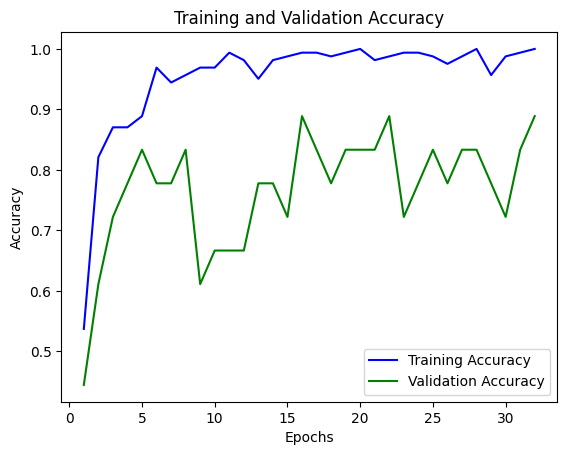


# Evaluate on test data
20/20 [==============================] - 0s 4ms/step - loss: 0.2413 - accuracy: 0.9000
Score for fold 1: loss of 0.24134814739227295; accuracy of 89.99999761581421%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.24134814739227295 - Accuracy: 89.99999761581421%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 89.99999761581421 (+- 0.0)
> Loss: 0.24134814739227295
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 2 ...

Current kl: 8
Current d: 0.1

Epoch 1/300

Epoch 1: val_loss improved from inf to 0.68548, saving model to /tmp/checkpoint.h5
11/11 - 4s - loss: 0.6881 - accuracy: 0.5309 - val_loss: 0.6855 - val_accuracy: 0.6111 - 4s/epoch - 328ms/step
Epo

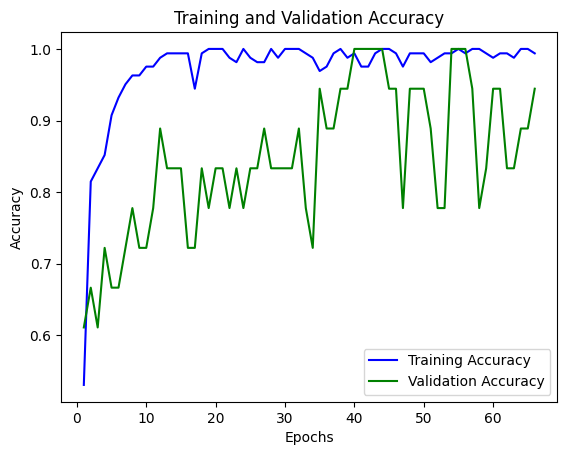


# Evaluate on test data
20/20 [==============================] - 0s 4ms/step - loss: 0.2146 - accuracy: 0.9000
Score for fold 2: loss of 0.21463000774383545; accuracy of 89.99999761581421%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.24134814739227295 - Accuracy: 89.99999761581421%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.21463000774383545 - Accuracy: 89.99999761581421%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 89.99999761581421 (+- 0.0)
> Loss: 0.2279890775680542
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 3 ...

Current kl: 8
Current d: 0.1

Epoch 1/300

Epoch 1: val_loss improved from inf to 0.68999, saving mo

In [ ]:
from sklearn.model_selection import KFold, train_test_split, LeaveOneOut, cross_val_score
from sklearn.utils import shuffle

# Choosing kernel length values
kl_values = [8, 16, 32, 64, 128]

# Controlling dropout values
d_values = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

# Number of selected maximum epochs to choose
n_epochs = 300

num_folds = 10

# enumerate splits
acc_per_fold = []
loss_per_fold = []

# Initialize a DataFrame to store the results
results_df = pd.DataFrame(columns=['AUC Score', 'kl', 'd'])


# Iterate over the event pair functions
for event_pair_function in event_pair_1:
    # Preprocess data for the current event pair
    epochs_selected = preprocess_data(event_pair_function, epoched_data)
    X = epochs_selected.get_data()
    y = epochs_selected.events[:, -1]

    X = min_max_scaler(X)
    X = mne_standard_scaler(X)
    encoder = OneHotEncoder(sparse_output=False)
    y = encoder.fit_transform(y.reshape(-1, 1))

    # Initialize DataFrame to store the results for each event pair
    results_df = pd.DataFrame(columns=['AUC Score', 'kl', 'd'])

    # Initialize variables to store the best parameters for each event pair
    highest_auc_score = 0
    best_kl = None
    best_d = None

    # KFold CV
    kf = KFold(n_splits=10, shuffle=True)

    for kl in kl_values:
        for d in d_values:
            print()
            print("Current kl:", kl)
            print("Current d:", d)
            print()

            # Initialize lists to store accuracy and loss per fold
            acc_per_fold = []
            loss_per_fold = []

            fold_counter = 1
            for train_index, test_index in kf.split(X, y):
                # Split the data into training and validation sets for this fold
                X_train, X_test = X[train_index, :], X[test_index, :]
                y_train, y_test = y[train_index], y[test_index]

                # Shuffle training set
                X_train, y_train = shuffle(X_train, y_train, random_state=42)

                # Shuffle test set
                X_test, y_test = shuffle(X_test, y_test, random_state=42)

                # Configure the EEGNet model
                model = EEGNet(nb_classes=2, Chans=204, Samples=2001, dropoutRate=d, kernLength=kl)

                # Compile the model
                model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

                # Generate a print
                print('------------------------------------------------------------------------')
                print(f'Training for fold {fold_counter} ...')
                print()
                print("Current kl:", kl)
                print("Current d:", d)
                print()

                # Set a valid path for model checkpoints
                checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1, save_best_only=True)

                # Class weights
                class_weights = {0: 1, 1: 1}

                # Fit the model to the training data
                history = model.fit(X_train, y_train, batch_size=16, epochs=n_epochs, verbose=2,
                                    validation_split=0.1, callbacks=[checkpointer, EarlyStopping(patience=10)])

                # Access the accuracy values from the history object
                train_accuracy = history.history['accuracy']
                val_accuracy = history.history['val_accuracy']

                # Plot the training and validation accuracy
                epochs = range(1, len(train_accuracy) + 1)
                plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
                plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
                plt.title('Training and Validation Accuracy')
                plt.xlabel('Epochs')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.show()

                print('\n# Evaluate on test data')
                results = model.evaluate(X_test, y_test, batch_size=1)
                print(f'Score for fold {fold_counter}: {model.metrics_names[0]} of {results[0]}; {model.metrics_names[1]} of {results[1]*100}%')

                acc_per_fold.append(results[1] * 100)
                loss_per_fold.append(results[0])

                fold_counter += 1

                # Check if the current AUC score is higher than the highest recorded score
                if results[1] * 100 > highest_auc_score:
                    highest_auc_score = results[1] * 100
                    best_kl = kl
                    best_d = d

                # Reset the Keras session to clear the model
                K.clear_session()

                                # == Provide average scores ==
                print('------------------------------------------------------------------------')
                print('Score per fold')
                for i in range(0, len(acc_per_fold)):
                    print('------------------------------------------------------------------------')
                    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')


                # Print the average accuracy and loss for the current kl and d combination
                print('------------------------------------------------------------------------')
                print('Average scores for all folds:')
                print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
                print(f'> Loss: {np.mean(loss_per_fold)}')
                print('------------------------------------------------------------------------')

                if fold_counter > num_folds:
                    break

            if fold_counter > num_folds:
                break

    # Append results for current event pair to dataframe
    results_df = results_df.append({'AUC Score': highest_auc_score, 'kl': best_kl, 'd': best_d}, ignore_index=True)

    # Print the event pair, highest AUC score, kl value, and d value
    print("Event Pair:", event_pair_function)
    print("Highest AUC Score:", highest_auc_score)
    print("Best kl value:", best_kl)
    print("Best d value:", best_d)

# Save the results to a file
out_f_name = '/content/drive/MyDrive/Maxwell Filtered Data/Combined Run data/acc_EEGNet_epochs_300_filtered_sub_3.npy'
np.save(out_f_name, results_df)

# Print the final results table
print(results_df)
